In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import optuna

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv
/kaggle/input/playground-series-s3e4/sample_submission.csv
/kaggle/input/playground-series-s3e4/train.csv
/kaggle/input/playground-series-s3e4/test.csv


**Downloading data**

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e4/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e4/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s3e4/sample_submission.csv')
addition_data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

train_df['is_generated'] = 1
test_df['is_generated'] = 1
addition_data['is_generated'] = 0

# addition_data = addition_data[addition_data['Class']==1]

In [3]:
addition_data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,is_generated
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,0


In [4]:
train_df = pd.concat([train_df, addition_data],axis=0, ignore_index=True)

In [5]:
train_df

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,is_generated
0,0.0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,...,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0,1
1,1.0,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,...,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0,1
2,2.0,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,...,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0,1
3,3.0,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,...,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0,1
4,4.0,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,...,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503931,NaN,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,0
503932,NaN,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,0
503933,NaN,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,0
503934,NaN,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,0


<AxesSubplot:>

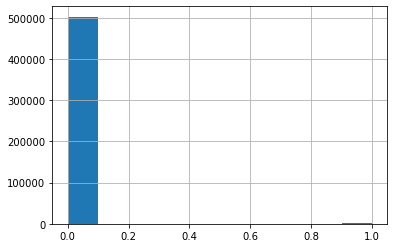

In [6]:
train_df.Class.hist()

In [7]:
df = pd.concat([train_df, test_df], axis=0)

In [8]:
df['hour'] = df['Time'] % (24 * 3600) // 3600
df['day'] = (df['Time'] // (24 * 3600)) % 7

In [9]:
def across_col_feat(df):
    '''
    Calculates features across colums...
    '''
    features = [feat for feat in df.columns if 'V' in feat]
    df['V_Sum'] = df[features].sum(axis = 1)
    df['V_Min'] = df[features].min(axis = 1)
    df['V_Max'] = df[features].max(axis = 1)
    df['V_Avg'] = df[features].mean(axis = 1)
    df['V_Std'] = df[features].std(axis = 1)
    df['V_Pos'] = df[features].gt(0).sum(axis = 1)
    df['V_Neg'] = df[features].lt(0).sum(axis = 1)
    df['V_Range'] = abs(df['V_Min'] - df['V_Max'])

    return df

df = across_col_feat(df)

In [10]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# y = df['Class']
# df = df.drop(['id','Class'], axis=1)

# df[df.columns] = scaler.fit_transform(df[df.columns])

In [11]:
from sklearn.preprocessing import RobustScaler
rscale = RobustScaler()

y = df['Class']
df = df.drop(['id','Class'], axis=1)

# df['Amount']=rscale.fit_transform(df['Amount'].values.reshape(-1,1))
# df['Time']=rscale.fit_transform(df['Time'].values.reshape(-1,1))

df[df.columns] = rscale.fit_transform(df[df.columns])

In [12]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,hour,day,V_Sum,V_Min,V_Max,V_Avg,V_Std,V_Pos,V_Neg,V_Range
0,-1.008662,0.891381,-0.125143,-0.700428,0.307221,-0.108300,-0.835775,0.093900,-0.610947,0.666656,...,-1.875,0.0,-0.709796,0.502942,0.268731,-0.709796,-0.449470,-0.75,0.75,-0.180941
1,-1.008662,0.856978,-0.908666,-0.375086,-0.508814,-0.801136,-0.027915,-0.900964,-0.012667,-0.021900,...,-1.875,0.0,-0.430501,0.459923,0.179102,-0.430501,-0.146562,-1.25,1.25,-0.202530
2,-1.008662,-0.012076,0.667096,-0.218062,-0.222138,0.532603,-0.645014,0.824740,-0.270132,0.032985,...,-1.875,0.0,-0.524849,0.737101,-1.001244,-0.524849,-0.822400,-0.75,0.75,-0.983237
3,-1.008662,0.848240,-0.163936,-0.661789,0.124512,-0.125138,-0.352995,-0.079350,-0.175867,0.782772,...,-1.875,0.0,-0.233557,0.191832,0.156336,-0.233557,-0.476091,-1.25,1.25,-0.056709
4,-1.008662,0.413665,-0.154768,0.535149,0.825943,-0.439063,1.150352,-0.821865,0.977309,0.626673,...,-1.875,0.0,0.928013,0.789572,-0.541977,0.928013,-0.470722,0.50,-0.50,-0.773793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146082,1.088941,-0.355348,-0.469970,0.288081,-0.296301,0.683361,-0.129952,0.137997,0.024995,0.631654,...,1.000,1.0,-1.174076,-0.468049,-1.161062,-1.174076,-0.450348,-0.25,0.25,-0.357804
146083,1.088941,-0.098842,0.497589,0.079313,-0.318446,0.569516,-0.020947,0.631111,-0.243084,0.144488,...,1.000,1.0,0.467728,0.587503,-0.668498,0.467728,-0.682613,0.25,-0.25,-0.721107
146084,1.088941,-0.731751,1.201309,0.191020,0.275213,0.077212,0.278027,0.492591,-0.222657,0.334990,...,1.000,1.0,1.448856,0.209681,-0.093557,1.448856,-0.313379,1.25,-1.25,-0.197970
146085,1.088953,-0.914950,-0.142920,-0.063985,-1.140743,-1.263569,0.822157,0.853943,-0.508402,-0.382416,...,1.000,1.0,-1.586508,-0.232731,-0.555834,-1.586508,0.370825,-1.00,1.00,-0.179565


Oversampling/undersampling idea from this amazing notebook:
https://www.kaggle.com/code/vaidyaprasad84/ps3-e4-eda-sampling-ft

In [13]:
train_df = df.iloc[:-len(test_df),:]
train_df['Class'] = y[:-len(test_df)]
test_df = df.iloc[-len(test_df):,:].reset_index(drop=True)

oversample = train_df[train_df['Class']==1]
undersample = train_df[train_df['Class']==0]

X = train_df.drop(['Class'], axis=1)
y = train_df.Class
X_test = test_df

In [14]:
# oversample1 = oversample[:200]
# undersample1 = undersample[:100000]

# oversample = oversample[200:]
# undersample = undersample[100000:]

In [15]:
# X1 = X[:50000]
# y1 = y[:50000]
# X = X[50000:]
# y = y[50000:]


**CatBoost regression model**

In [16]:
# from sklearn.model_selection import train_test_split
# import catboost
# from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
# from sklearn.metrics import roc_auc_score

# from sklearn.model_selection import cross_val_score

# def catboost_objective(trial):
#     learning_rate = trial.suggest_float('learning_rate', 0, 0.3)
#     depth = trial.suggest_int('depth', 3, 10)
# #     n_estimators = trial.suggest_int('n_estimators', 50, 500)
# #     subsample = trial.suggest_float('subsample', 0, 1)
# #     l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 1, 100)
# #     min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 100)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
#     model = catboost.CatBoostRegressor(
#                 random_seed = 1234,             
# #                 iterations = 5000,
# #                 early_stopping_rounds = 1000,
# #                 use_best_model = True,
#                 eval_metric = 'RMSE',
#                 verbose = 5000,
    
#                  depth = depth, 
#                  learning_rate = learning_rate, 
#                  rsm = 0.5,
#                  subsample = 0.931, 
#                  l2_leaf_reg = 69,
#                  min_data_in_leaf = 20,
#                  random_strength = 0.175,
#     )
    
#     model.fit(X_train, y_train)  

# #     kf = KFold(n_splits= 5)
# #     cv_score = cross_val_score(model, X, y, scoring= 'roc_auc', cv= kf)
#     return roc_auc_score(y_test, model.predict(X_test))

# study = optuna.create_study(direction= 'maximize')
# study.optimize(catboost_objective, n_trials= 50)


In [17]:
# study.best_params

In [18]:
import catboost
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score

n_folds = 2
repeats = 30
sample_size = 150000 # 200 000

MAX_ITER = 15000
PATIENCE = 1000
DISPLAY_FREQ = 100

modelsCB = []
predsCB = []

# k_fold = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42) 

MODEL_PARAMS = {
                'random_seed': 1234,             
                'iterations': MAX_ITER,
                'early_stopping_rounds': PATIENCE,
#                 'use_best_model': True,
                'eval_metric': 'RMSE',
                'verbose': 1000,
    
                 'depth': 7, #3, 
                 'learning_rate': 0.1177165005048142, #0.01177165005048142, #0.2238051305181816,
                 'rsm': 0.5,
                 'subsample': 0.931, 
                 'l2_leaf_reg': 69, 
                 'min_data_in_leaf': 20, 
                 'random_strength': 0.175,
               }

catboost_params = {'n_estimators': 500,
                   'learning_rate': 0.03, 
                   'one_hot_max_size': 12,
                   'depth': 4,
                   'l2_leaf_reg': 0.014,
                   'colsample_bylevel': 0.06,
                   'min_data_in_leaf': 12,
                   'boosting_type': 'Plain',
                   'bootstrap_type': 'Bernoulli',
                   'verbose': False}


# for train_index, test_index in k_fold.split(X, y):
#     X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
# #     model = catboost.CatBoostClassifier(**MODEL_PARAMS)
#     model = catboost.CatBoostRegressor(**MODEL_PARAMS)
    
#     model.fit(X=X_train, y=y_train,
#           eval_set=[(X_valid, y_valid)],
#           early_stopping_rounds = PATIENCE,
# #           metric_period = DISPLAY_FREQ
#          )
#     modelsCB.append(model)
#     predsCB.append(model.predict(X_test))
    
for i in range(repeats):
    sample = undersample.sample(n=sample_size)
    merged = pd.concat([oversample,sample])
    X = merged.drop('Class', axis=1)
    y = merged['Class']
    model = catboost.CatBoostRegressor(**catboost_params)
    model.fit(X,y,
             early_stopping_rounds = PATIENCE,)
    modelsCB.append(model)
    predsCB.append(model.predict(X_test))

**CatBoost classifier model**

In [19]:
# from sklearn.model_selection import train_test_split
# import catboost
# from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
# from sklearn.metrics import roc_auc_score

# from sklearn.model_selection import cross_val_score

# def catboost_cl_objective(trial):
#     learning_rate = trial.suggest_float('learning_rate', 0, 0.3)
#     depth = trial.suggest_int('depth', 3, 10)
# #     n_estimators = trial.suggest_int('n_estimators', 50, 500)
# #     subsample = trial.suggest_float('subsample', 0, 1)
# #     l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 1, 100)
# #     min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 100)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
#     model = catboost.CatBoostClassifier(
#                 random_seed = 1234,             
# #                 iterations = 5000,
# #                 early_stopping_rounds = 1000,
# #                 use_best_model = True,
#                 eval_metric = 'AUC',
#                 verbose = 5000,
    
#                  depth = depth, 
#                  learning_rate = learning_rate, 
#                  rsm = 0.5,
#                  subsample = 0.931, 
#                  l2_leaf_reg = 69,
#                  min_data_in_leaf = 20,
#                  random_strength = 0.175,
#     )
    
#     model.fit(X_train, y_train)  

# #     kf = KFold(n_splits= 5)
# #     cv_score = cross_val_score(model, X, y, scoring= 'roc_auc', cv= kf)
#     return roc_auc_score(y_test, model.predict(X_test))

# study = optuna.create_study(direction= 'maximize')
# study.optimize(catboost_cl_objective, n_trials= 50)


In [20]:
# study.best_params

In [21]:
MAX_ITER = 15000
PATIENCE = 1000
DISPLAY_FREQ = 100

modelsCBC = []
predsCBC = []

# k_fold = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42) 

MODEL_PARAMS = {
                'random_seed': 1234,             
                'iterations': MAX_ITER,
                'early_stopping_rounds': PATIENCE,
#                 'use_best_model': True,
                'eval_metric': 'AUC',
#                 'eval_metric': 'RMSE',
                'verbose': 1000,
    
                 'depth': 6, #3, 
                 'learning_rate': 0.08989547995455076, #0.2238051305181816, 
                 'rsm': 0.5,
                 'subsample': 0.931, 
                 'l2_leaf_reg': 69, 
                 'min_data_in_leaf': 20, 
                 'random_strength': 0.175,
               }
catboost_params = {'n_estimators': 500,
                   'learning_rate': 0.03, 
                   'one_hot_max_size': 12,
                   'depth': 4,
                   'l2_leaf_reg': 0.014,
                   'colsample_bylevel': 0.06,
                   'min_data_in_leaf': 12,
                   'boosting_type': 'Plain',
                   'bootstrap_type': 'Bernoulli',
                   'verbose': False}

# for train_index, test_index in k_fold.split(X, y):
#     X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
#     model = catboost.CatBoostClassifier(**MODEL_PARAMS)
# #     model = catboost.CatBoostRegressor(**MODEL_PARAMS)
    
#     model.fit(X=X_train, y=y_train,
#           eval_set=[(X_valid, y_valid)],
#           early_stopping_rounds = PATIENCE,
# #           metric_period = DISPLAY_FREQ
#          )
#     modelsCBC.append(model)
#     predsCBC.append(model.predict_proba(X_test)[:, 1])
    
for i in range(repeats):
    sample = undersample.sample(n=sample_size)
    merged = pd.concat([oversample,sample])
    X = merged.drop('Class', axis=1)
    y = merged['Class']
    model = catboost.CatBoostClassifier(**catboost_params)
    model.fit(X,y,
             early_stopping_rounds = PATIENCE,)
    modelsCBC.append(model)
    predsCBC.append(model.predict_proba(X_test)[:, 1])

**XGBoost regression model**

In [22]:
# from sklearn.model_selection import train_test_split
# import catboost
# from xgboost import XGBClassifier, XGBRegressor
# from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
# from sklearn.metrics import roc_auc_score

# from sklearn.model_selection import cross_val_score

# def xgboost_objective(trial):
#     learning_rate = trial.suggest_float('learning_rate', 0, 0.3)
#     depth = trial.suggest_int('depth', 3, 10)
# #     n_estimators = trial.suggest_int('n_estimators', 50, 500)
# #     subsample = trial.suggest_float('subsample', 0, 1)
# #     l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 1, 100)
# #     min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 100)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
#     model = XGBRegressor(
#                 n_estimators  = 2145,
#               min_child_weight = 96,
#               max_depth = depth,
#               learning_rate = learning_rate,
#               subsample = 0.95,
#               colsample_bytree = 0.95,
#               reg_lambda = 1.50,
#               reg_alpha = 1.50,
#               gamma = 1.50,
#               max_bin = 512,
#               random_state = 42,
# #               'objective'        : 'binary:logistic',
# #               early_stopping_rounds = 200,
#               tree_method = 'hist',
#               eval_metric = 'rmse',
#     )
    
#     model.fit(X_train, y_train)  

# #     kf = KFold(n_splits= 5)
# #     cv_score = cross_val_score(model, X, y, scoring= 'roc_auc', cv= kf)
#     return roc_auc_score(y_test, model.predict(X_test))

# study = optuna.create_study(direction= 'maximize')
# study.optimize(xgboost_objective, n_trials= 50)


In [23]:
# study.best_params

In [24]:
from xgboost import XGBClassifier, XGBRegressor

# k_fold = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42) 

modelsXB = []
predsXB = []

PATIENCE = 200

# MODEL_PARAMS = {       'n_estimators': 5000, 
#                        'learning_rate': 0.04625397031701272, #0.04625397031701272, 0.06733333333333334
#                        'max_depth': 3, #3, 29
#                        'colsample_bytree': 0.9, #0.12954517333371557, #0.9, #0.9, 0.99
#                        'subsample': 1, #0.7426054009856451, #1, #1, 0.99
# #                        'min_child_weight': 12, #
# #                        'gamma': 0.11888888888888888, #
#                        'reg_lambda': 20, #55, #20,
# #                        'eval_metric': 'auc',
#                        'eval_metric': 'rmse',
#                        'early_stopping_rounds': PATIENCE,
# #                        'tree_method': 'gpu_hist',
#                        'seed': 1
# }

MODEL_PARAMS = {'n_estimators'     : 2145,
              'min_child_weight' : 96,
              'max_depth'        : 8, #7,
              'learning_rate'    : 0.04791309460309468, #0.18,
              'subsample'        : 0.95,
              'colsample_bytree' : 0.95,
              'reg_lambda'       : 1.50,
              'reg_alpha'        : 1.50,
              'gamma'            : 1.50,
              'max_bin'          : 512,
              'random_state'     : 42,
#               'objective'        : 'binary:logistic',
#               'early_stopping_rounds': PATIENCE,
              'tree_method'      : 'hist',
              'eval_metric'      : 'rmse', #'auc'
             } 

xgb_params = {'n_estimators'     : 2000,
              'min_child_weight' : 96,
              'max_depth'        : 7,
              'learning_rate'    : 0.18,
              'subsample'        : 0.95,
              'colsample_bytree' : 0.95,
              'reg_lambda'       : 1.50,
              'reg_alpha'        : 1.50,
              'gamma'            : 1.50,
              'max_bin'          : 512,
              'random_state'     : 42,
              'objective'        : 'binary:logistic',
              'tree_method'      : 'hist',
              'eval_metric'      : 'rmse', #'auc'
             }

# for train_index, test_index in k_fold.split(X, y):
#     X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
# #     model = XGBClassifier(**MODEL_PARAMS)
#     model = XGBRegressor(**MODEL_PARAMS)
    
#     model.fit(X=X_train, y=y_train,
#           eval_set=[(X_valid, y_valid)],
# #           early_stopping_rounds = PATIENCE,
#           verbose = 100
#          )
#     modelsXB.append(model)
#     predsXB.append(model.predict(X_test))
    
for i in range(repeats):
    sample = undersample.sample(n=sample_size)
    merged = pd.concat([oversample,sample])
    X = merged.drop('Class', axis=1)
    y = merged['Class']
    model = XGBRegressor(**xgb_params)
    model.fit(X,y,verbose = 100,
#              early_stopping_rounds = PATIENCE,
             )
    modelsXB.append(model)
    predsXB.append(model.predict(X_test))

**XGBoost classifier model**

In [25]:
# from sklearn.model_selection import train_test_split
# import catboost
# from xgboost import XGBClassifier, XGBRegressor
# from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
# from sklearn.metrics import roc_auc_score

# from sklearn.model_selection import cross_val_score

# def xgboost_cl_objective(trial):
#     learning_rate = trial.suggest_float('learning_rate', 0, 0.3)
#     depth = trial.suggest_int('depth', 3, 10)
# #     n_estimators = trial.suggest_int('n_estimators', 50, 500)
# #     subsample = trial.suggest_float('subsample', 0, 1)
# #     l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 1, 100)
# #     min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 100)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
#     model = XGBClassifier(
#                 n_estimators  = 2145,
#               min_child_weight = 96,
#               max_depth = depth,
#               learning_rate = learning_rate,
#               subsample = 0.95,
#               colsample_bytree = 0.95,
#               reg_lambda = 1.50,
#               reg_alpha = 1.50,
#               gamma = 1.50,
#               max_bin = 512,
#               random_state = 42,
# #               'objective'        : 'binary:logistic',
# #               early_stopping_rounds = 200,
#               tree_method = 'hist',
#               eval_metric = 'auc',
#     )
    
#     model.fit(X_train, y_train)  

# #     kf = KFold(n_splits= 5)
# #     cv_score = cross_val_score(model, X, y, scoring= 'roc_auc', cv= kf)
#     return roc_auc_score(y_test, model.predict(X_test))

# study = optuna.create_study(direction= 'maximize')
# study.optimize(xgboost_cl_objective, n_trials= 50)


In [26]:
# study.best_params

In [27]:
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42) 

modelsXBC = []
predsXBC = []

PATIENCE = 200

# MODEL_PARAMS = {       'n_estimators': 5000, 
#                        'learning_rate': 0.04625397031701272, #0.02910875107189472, #0.04625397031701272, 0.06733333333333334
#                        'max_depth': 3, #4, #3, 29
#                        'colsample_bytree': 0.9, #0.11912735505392935, #0.9, #0.9, 0.99
#                        'subsample': 1, #0.7605555695727094, # 1, #1, 0.99
# #                        'min_child_weight': 12, #
# #                        'gamma': 0.11888888888888888, #
#                        'reg_lambda': 20, #17, #20,
#                        'eval_metric': 'auc',
# #                        'eval_metric': 'rmse',
#                        'early_stopping_rounds': PATIENCE,
# #                        'tree_method': 'gpu_hist',
#                        'seed': 1
# }

MODEL_PARAMS = {'n_estimators'     : 2145,
              'min_child_weight' : 96,
              'max_depth'        : 5, #7,
              'learning_rate'    : 0.25242368703215484, #0.18,
              'subsample'        : 0.95,
              'colsample_bytree' : 0.95,
              'reg_lambda'       : 1.50,
              'reg_alpha'        : 1.50,
              'gamma'            : 1.50,
              'max_bin'          : 512,
              'random_state'     : 42,
              'objective'        : 'binary:logistic',
#               'early_stopping_rounds': PATIENCE,
              'tree_method'      : 'hist',
              'eval_metric'      : 'auc'
             }

xgb_params = {'n_estimators'     : 2000,
              'min_child_weight' : 96,
              'max_depth'        : 7,
              'learning_rate'    : 0.18,
              'subsample'        : 0.95,
              'colsample_bytree' : 0.95,
              'reg_lambda'       : 1.50,
              'reg_alpha'        : 1.50,
              'gamma'            : 1.50,
              'max_bin'          : 512,
              'random_state'     : 42,
              'objective'        : 'binary:logistic',
              'tree_method'      : 'hist',
              'eval_metric'      : 'auc'
             }

# for train_index, test_index in k_fold.split(X, y):
#     X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
#     model = XGBClassifier(**MODEL_PARAMS)
# #     model = XGBRegressor(**MODEL_PARAMS)
    
#     model.fit(X=X_train, y=y_train,
#           eval_set=[(X_valid, y_valid)],
# #           early_stopping_rounds = PATIENCE,
#           verbose = 100
#          )
#     modelsXBC.append(model)
#     predsXBC.append(model.predict_proba(X_test)[:, 1])
    
for i in range(repeats):
    sample = undersample.sample(n=sample_size)
    merged = pd.concat([oversample,sample])
    X = merged.drop('Class', axis=1)
    y = merged['Class']
    model = XGBClassifier(**xgb_params)
    model.fit(X,y,verbose = 100,
#              early_stopping_rounds = PATIENCE,
             )
    modelsXBC.append(model)
    predsXBC.append(model.predict_proba(X_test)[:, 1])

In [28]:
import lightgbm as lgbm

k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42) 

modelsLBC = []
predsLBC = []

# PATIENCE = 200

params={
             'objective': 'binary',
             'metric': 'auc',
             'lambda_l1': 1.0050418664783436e-08, 
             'lambda_l2': 9.938606206413121,
             'scale_pos_weight': 1, #param could be ignored
             'num_leaves': 44,
             'feature_fraction': 0.8247273276668773,
             'bagging_fraction': 0.5842711778104962,
             'bagging_freq': 6,
             'min_data_in_leaf': 134,
             'min_child_samples': 70,
             'max_depth': 8,
             'num_iterations': 400,
             'learning_rate':0.05}

lgbm_params = {'n_estimators': 500,
                 'num_rounds': 274,
                 'learning_rate': 0.1,
                 'num_leaves': 195,
                 'max_depth': 9,
                 'min_data_in_leaf': 46,
                 'lambda_l1': 0.01,
                 'lambda_l2': 0.6,
                 'min_gain_to_split': 1.42,
                 'bagging_fraction': 0.45,
                 'feature_fraction': 0.3,
                 'verbose':-1}

# for train_index, test_index in k_fold.split(X, y):
#     X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
#     model = lgbm.LGBMClassifier(**params)
# #     model = lgbm.LGBMRegressor(**MODEL_PARAMS)
    
#     model.fit(X=X_train, y=y_train,
#           eval_set=[(X_valid, y_valid)],
#           early_stopping_rounds = 50,
#           verbose = 100
#          )
#     modelsLBC.append(model)
#     predsLBC.append(model.predict_proba(X_test)[:, 1])
    
for i in range(repeats):
    sample = undersample.sample(n=sample_size)
    merged = pd.concat([oversample,sample])
    X = merged.drop('Class', axis=1)
    y = merged['Class']
    model = lgbm.LGBMClassifier(**lgbm_params)
    model.fit(X=X,y=y,verbose = 100,
#              early_stopping_rounds = PATIENCE,
             )
    modelsLBC.append(model)
    predsLBC.append(model.predict_proba(X_test)[:, 1])

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.45, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45
[LightGBM] [Warning] num_iterations is set=274, num_rounds=274 will be ignored. Current value: num_iterations=274
[LightGBM] [Warning] min_gain_to_split is set=1.42, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.42
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.45, subsample=1.0 will be ignored.

In [29]:
import lightgbm as lgbm

k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42) 

modelsLB = []
predsLB = []

# PATIENCE = 200

params={
#              'objective': 'binary',
             'metric': 'rmse',
             'lambda_l1': 1.0050418664783436e-08, 
             'lambda_l2': 9.938606206413121,
             'scale_pos_weight': 1, #param could be ignored
             'num_leaves': 44,
             'feature_fraction': 0.8247273276668773,
             'bagging_fraction': 0.5842711778104962,
             'bagging_freq': 6,
             'min_data_in_leaf': 134,
             'min_child_samples': 70,
             'max_depth': 8,
             'num_iterations': 400,
             'learning_rate':0.05}

lgbm_params = {'n_estimators': 500,
                 'num_rounds': 274,
                 'learning_rate': 0.1,
                 'num_leaves': 195,
                 'max_depth': 9,
                 'min_data_in_leaf': 46,
                 'lambda_l1': 0.01,
                 'lambda_l2': 0.6,
                 'min_gain_to_split': 1.42,
                 'bagging_fraction': 0.45,
                 'feature_fraction': 0.3,
                 'verbose':-1}

# for train_index, test_index in k_fold.split(X, y):
#     X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
# #     model = lgbm.LGBMClassifier(**MODEL_PARAMS)
#     model = lgbm.LGBMRegressor(**params)
    
#     model.fit(X=X_train, y=y_train,
#           eval_set=[(X_valid, y_valid)],
#           early_stopping_rounds = 50,
#           verbose = 100
#          )
#     modelsLB.append(model)
#     predsLB.append(model.predict(X_test))
    
for i in range(repeats):
    sample = undersample.sample(n=sample_size)
    merged = pd.concat([oversample,sample])
    X = merged.drop('Class', axis=1)
    y = merged['Class']
    model = lgbm.LGBMRegressor(**lgbm_params)
    model.fit(X=X,y=y,verbose = 100,
#              early_stopping_rounds = PATIENCE,
             )
    modelsLB.append(model)
    predsLB.append(model.predict(X_test))

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.45, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45
[LightGBM] [Warning] num_iterations is set=274, num_rounds=274 will be ignored. Current value: num_iterations=274
[LightGBM] [Warning] min_gain_to_split is set=1.42, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.42
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.45, subsample=1.0 will be ignored.

**Lasso linear regression**

In [30]:
from sklearn.linear_model import LassoCV, Lasso

# n_folds = 20
# k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=2*repeats, random_state=42) # 20

modelsLR = []
predsLR = []

MODEL_PARAMS = {
                       'precompute': "auto",
                       'fit_intercept': True,
                       'normalize': False,
                       'max_iter': 10000,
                       'verbose': False,
                       'eps': 0.000001, #1e-04, #0.007267206407101401, #1e-04,
                       'cv': 5, #6, #5,
                       'n_alphas': 1000,
                       'n_jobs': 8,
                       'tol': 0.0001
}



# for train_index, test_index in k_fold.split(X, y):
#     X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
#     model = LassoCV(**MODEL_PARAMS)
    
#     model.fit(X=X_train, y=y_train,
# #           eval_set=[(X_valid, y_valid)],
#          )
    
#     modelsLR.append(model)
#     predsLR.append(model.predict(X_test))
    
for i in range(repeats):
    sample = undersample.sample(n=sample_size)
    merged = pd.concat([oversample,sample])
    X = merged.drop('Class', axis=1)
    y = merged['Class']
    model = Lasso(alpha=0.001)
    model.fit(X,y,
#              early_stopping_rounds = PATIENCE,
             )
    modelsLR.append(model)
    predsLR.append(model.predict(X_test))

In [31]:
from sklearn.metrics import roc_auc_score

 
def coef_objective(trial):
    a = trial.suggest_float('a', 0, 1)
    b = trial.suggest_float('b', 0, 1)
    c = trial.suggest_float('c', 0, 1)
    d = trial.suggest_float('d', 0, 1)
    e = trial.suggest_float('e', 0, 1)
    f = trial.suggest_float('f', 0, 1)
#     g = trial.suggest_float('g', 0, 1)
        
#     merged = pd.concat([oversample1,undersample1])
#     X = merged.drop('Class', axis=1)
#     y = merged['Class']

#     X = X1
#     y = y1
    
    preds_eval = []
    for model in modelsCB:
        preds_eval.append(model.predict(X))
    
    resCB = np.average(np.array(preds_eval),axis=0)

    preds_eval = []
    for model in modelsXB:
        preds_eval.append(model.predict(X))
    
    resXB = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsCBC:
        preds_eval.append(model.predict_proba(X)[:, 1])
    
    resCBC = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsXBC:
        preds_eval.append(model.predict_proba(X)[:, 1])
    
    resXBC = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsLBC:
        preds_eval.append(model.predict_proba(X)[:, 1])
    
    resLBC = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsLB:
        preds_eval.append(model.predict(X))
    
    resLB = np.average(np.array(preds_eval),axis=0)


#     preds_eval = []
#     for model in modelsLR:
#         preds_eval.append(model.predict(X))
    
#     resLR = np.average(np.array(preds_eval),axis=0)

    res = roc_auc_score(y,
                        (resCB * a + resXB * b + resCBC * c + resXBC * d + resLBC * e + 
                         resLB * f )/(a + b + c + d + e + f))

    return res

study = optuna.create_study(direction= 'maximize')
# study.optimize(coef_objective, n_trials= 100)


[I 2023-01-28 08:31:56,877] A new study created in memory with name: no-name-f0d50087-d149-4034-a97f-a44d7d2f5237


In [32]:
# study.best_params

In [33]:
# a = study.best_params['a']
# b = study.best_params['b']
# c = study.best_params['c']
# d = study.best_params['d']
# e = study.best_params['e']
# f = study.best_params['f']
# # g = study.best_params['g']

# sum_coef = a + b + c + d + e + f
# a = a / sum_coef
# b = b / sum_coef
# c = c / sum_coef
# d = d / sum_coef
# e = e / sum_coef
# f = f / sum_coef
# # g = g / sum_coef

# a, b, c, d, e, f

In [34]:
# a = 0.3669557354589081
# b = 0.337641198537538
# c = 0.008900837188394609
# d = 0.2447433523478509
# e = 0.04175887646730838

In [35]:
# a = 0.14719373356287416
# b = 0.21197835016639707
# c = 0.5218752467435989
# d = 0.11810079201731347
# e = 0.0008518775098164659

In [36]:
# a = 0.013732712049429857
# b = 0.11139158723935387
# c = 0.7579975888425357
# d = 0.11626614433593775
# e = 0.0006119675327428372

In [37]:
# a = 0.004924244009922518 + 0.011877491530298148
# b = 0.3117566542173961
# c = 0.10166065209557595
# d = 0.0503241817163487
# e = 0.4682759529883892
# f = 0.051180823442069395
# g = 0 #0.011877491530298148

In [38]:
# a = 0.17
# b = 0.16
# c = 0.17
# d = 0.17
# e = 0.17
# f = 0.16
# g = 0 

In [39]:
# a = 0.15
# b = 0.14
# c = 0.15
# d = 0.14
# e = 0.14
# f = 0.14
# g = 0.14

# a = 0.13
# b = 0.14
# c = 0.2
# d = 0.2
# e = 0.2
# f = 0.13
# g = 0 

# a = 0.2
# b = 0.2
# c = 0.13
# d = 0.14
# e = 0.13
# f = 0.2
# g = 0 

# a = 0.23
# b = 0.23
# c = 0.1
# d = 0.11
# e = 0.1
# f = 0.23
# g = 0

# 0.87022

# a = 0.25
# b = 0.25
# c = 0.08
# d = 0.09
# e = 0.08
# f = 0.25
# g = 0

# 0.86927

# a = 0.22
# b = 0.22
# c = 0.11
# d = 0.12
# e = 0.11
# f = 0.22
# g = 0

# 0.86997

a = 0.24
b = 0.24
c = 0.09
d = 0.10
e = 0.09
f = 0.24
g = 0

# 0.87044

# a = 0.235
# b = 0.235
# c = 0.095
# d = 0.105
# e = 0.095
# f = 0.235
# g = 0

# 0.86909

In [40]:
# a = 0.008764460310928566
# b = 0.2964161989525224
# c = 0.19274616797827318
# d = 0.3180908607731729
# e = 0.18358232512438427
# f = 0.00039998686071876055
# g = 0 

In [41]:
predCB = np.average(np.array(predsCB),axis=0).clip(0,1)
predXB = np.average(np.array(predsXB),axis=0).clip(0,1)
predCBC = np.average(np.array(predsCBC),axis=0).clip(0,1)
predXBC = np.average(np.array(predsXBC),axis=0).clip(0,1)
predLBC = np.average(np.array(predsLBC),axis=0).clip(0,1)
predLB = np.average(np.array(predsLB),axis=0).clip(0,1)
predLR = np.average(np.array(predsLR),axis=0).clip(0,1)

pred = predCB * a + predXB * b + predCBC * c + predXBC * d + predLBC * e + predLB * f + predLR * g

<AxesSubplot:>

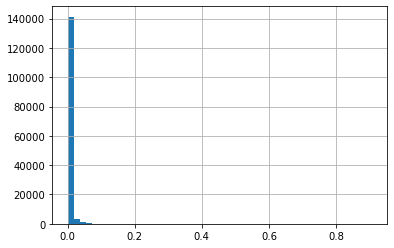

In [42]:
pd.Series(predCB).hist(bins=50)

<AxesSubplot:>

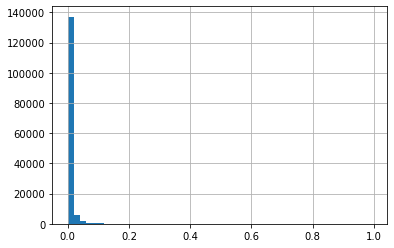

In [43]:
pd.Series(predXB).hist(bins=50)

<AxesSubplot:>

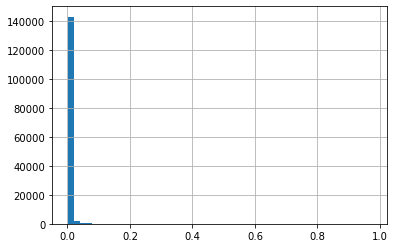

In [44]:
pd.Series(predCBC).hist(bins=50)

<AxesSubplot:>

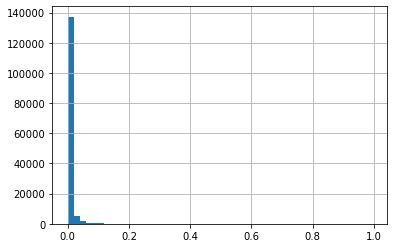

In [45]:
pd.Series(predXBC).hist(bins=50)

<AxesSubplot:>

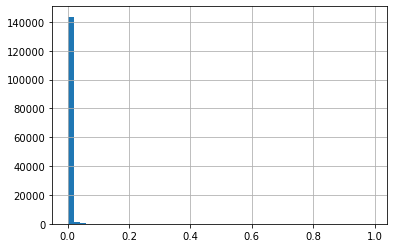

In [46]:
pd.Series(predLBC).hist(bins=50)

<AxesSubplot:>

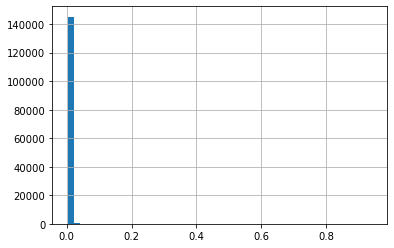

In [47]:
pd.Series(predLB).hist(bins=50)

<AxesSubplot:>

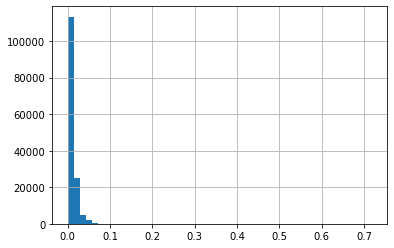

In [48]:
predLR = np.average(np.array(predsLR),axis=0).clip(0,1)
pd.Series(predLR).hist(bins=50)

<AxesSubplot:>

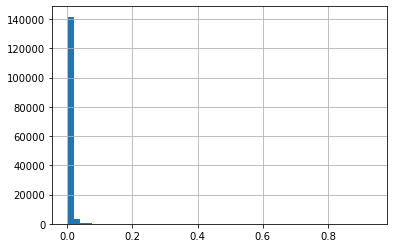

In [49]:
pd.Series(pred).hist(bins=50)

**Making submission**

In [50]:
submission['Class'] = pred
submission

,id,Class
0,219129,0.006258
1,219130,0.003191
2,219131,0.002079
3,219132,0.004002
4,219133,0.002473
...,...,...
146082,365211,0.001955
146083,365212,0.002399
146084,365213,0.002548
146085,365214,0.001790


In [51]:
submission.to_csv('submission.csv', index=False)